# 1. Pre-Processing of Data

This notebook goes deeply into the data pipeline's preparation phase. The iRealPro Corpus of Jazz Standards is the core dataset under consideration. This phase's overarching goals include the following:

- **Extraction**: In this first step, chords are retrieved from the dataset.

- **Arrangement**: Once extracted, the chords are arranged and flattend to one timestep at a time. 

- **Simplification**: There exists a ton of chord extensions, substitutions, and variations. This complexity can be reduced by simplifying the data, which makes it easier to work with and better for modeling without giving up the important harmonic essence.

The variable `print_output` will decide if after every step the output is printed, this us usefull for debugging or curious minds.

In [1]:
import os, glob, random
from functions.utils import extract_chords, flatten_chords, flatten_chords_half, extract_year

from functions.ChordSimplifier import ChordSimplifier
from functions.utils import visualize_chord_simplification

print_output = True

## Pipeline

### Open all Files
1. Save it in the variable `all_chords`.
2. Flatten the Data.

In [2]:
def get_jazz_files(directory):
    jazz_files = []
    for file_path in glob.glob(os.path.join(directory, "*.jazz")):
        jazz_files.append(file_path)
    return jazz_files

jazz_files = get_jazz_files("data")

Lets look at a datapoint before we flatten it and after:

In [3]:
with open ("data/conferenceofthebirds.jazz", "r") as fh:
    text = fh.read()

extracted = extract_chords(text)
print(extracted)
arranged = flatten_chords(extracted) 
print(arranged)
print(extract_year(text))

['2.D:min', '2F', '2.B-', '2E-', '2.D:min', '2F', '2.B-', '2E-']
['D:min', 'D:min', 'D:min', 'F', 'F', 'B-', 'B-', 'B-', 'E-', 'E-', 'D:min', 'D:min', 'D:min', 'F', 'F', 'B-', 'B-', 'B-', 'E-', 'E-']
1973


#### Composition times

In [12]:
year_counter= {}
for jazz in jazz_files:
    with open(jazz, "r") as fh:
        text = fh.read()
    yr = extract_year(text)[:4]
    if yr not in year_counter.keys(): year_counter[yr] = 0
    else: year_counter[yr] +=1

print(year_counter)

{'1939': 23, '1959': 45, '1965': 26, '1958': 14, '1986': 4, '1951': 14, '1953': 23, '1940': 28, '1956': 34, '1947': 30, '1967': 23, '1934': 25, '1952': 15, '1925': 6, '1969': 3, '1964': 33, '1924': 11, '1930': 26, '1937': 34, '1955': 19, '1950': 10, '1944': 34, '1961': 17, '1917': 2, '1932': 24, '1976': 7, '1933': 17, '1963': 31, '1957': 23, '1929': 20, '1984': 0, '1954': 28, '1941': 30, '1942': 20, '1960': 24, '1931': 20, '1938': 24, '1972': 8, '1936': 23, '1923': 3, '1968': 10, '1926': 12, '1946': 31, '1943': 12, '1949': 22, '1928': 20, '1982': 0, '1935': 22, '1974': 7, '1973': 5, '1966': 21, '1988': 1, '1927': 12, '1902': 0, '1945': 23, '1920': 2, '1975': 5, '1911': 1, '1979': 4, '2007': 0, '1977': 5, '1948': 17, '1998': 4, '1989': 1, '2002': 0, '1994': 0, '1978': 9, '1999': 2, '1971': 6, '1962': 24, '1990': 4, '1985': 1, '1916': 0, '1970': 5, '1983': 0, '1919': 1, '1980': 3, '1922': 1, '1996': 0, '1981': 0, '1914': 1, '1896': 0, '2001': 0, '1992': 1, '1921': 0, '1995': 0, '1918': 0

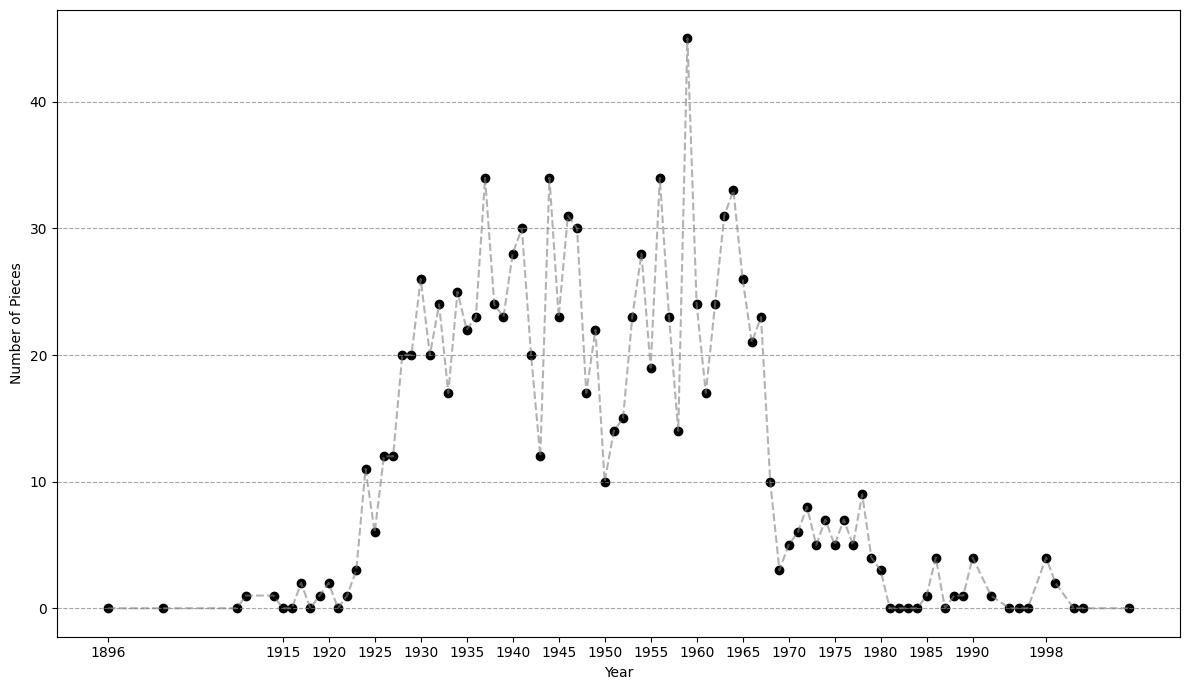

In [16]:
import matplotlib.pyplot as plt

data = year_counter

# Extract years (as integers) and their respective counts
years = sorted([int(year) for year in data.keys()])
counts = [data[str(year)] for year in years]

# Plotting the data
plt.figure(figsize=(12, 7))
plt.scatter(years, counts, marker='o', color='black')
plt.plot(years, counts, color='gray', linestyle='--', alpha=0.6)
#plt.title("Distribution of Pieces by Year")
plt.xlabel("Year")
plt.ylabel("Number of Pieces")
plt.grid(True, axis='y', linestyle='--', alpha=0.7, color='gray')

# Display every nth year to avoid clutter. 
n = 5
visible_years = years[::n]
plt.xticks(visible_years)

plt.tight_layout()

# Display the plot
plt.savefig("img/DistrbutionbyYear.png")
plt.show()


#### Note lenghts
Lets look at the note lenghts. Is there notes shorter than a fourth (1/4)? any other special cases?

In [5]:
durations = {}
for file in jazz_files:
    with open(file, "r") as fh:
        text = fh.read()
    
    chords = extract_chords(text)
    for chord in chords:
        if len(chord) == 1:
            continue
            
        if chord [1] == ".":
            duration = chord[:2]
        else:
            duration = chord[0]

        if duration not in durations.keys():
            durations[duration] = 1
        else:
            durations[duration] += 1  

durations

{'1': 23967, '2': 29572, '4': 2503, '2.': 3492, '4.': 454, '1.': 102, '8': 30}

We have the follwoing durations:
`{'1': 23967, '2': 29572, '4': 2503, '2.': 3492, '4.': 454, '1.': 102, '8': 30}`

Observe that we have just a bit eight notes (8). They will be converted to fourth, becuse otherwise we have to change the sequcne rythm we feed into the network from 1/4 per sequnce to 1/8 per sequnce - which would double the seunce lenght and then skew the predictions from one chord to the same often times, which is not desired. Since we also have the same problem with the `4.` note since its a sixth (1/6), we will also prune this to a fouth (1/4).

The follwoing rules will now hold:
- Each timestep of the RNN will be 1/4 Bar.
- `8` (eight) be converted to a 1/4
- `4.` (fourth dotted) will be converted to 1/4

#### Time signatures
How are the time signatures distributed?

In [6]:
from functions.utils import extract_signature
time_signatures = {}

for file in jazz_files:
    with open(file, "r") as fh:
        text = fh.read()

    time = extract_signature(text)
        
    if time not in time_signatures.keys():
        time_signatures[time] = 1
    else:
        time_signatures[time] += 1

time_signatures

{'4/4': 1099, '3/4': 79, '6/4': 3, '5/4': 3, '3/2': 1, '6/8': 1}

### Get all chords
Open all the files in the directory, then save it to a variable `all_chords`.

In [30]:
all_chords = []
quarter_note_files = 0
eight_note_files = 0

non_44 = 0
non_half = 0
durations_new = {}
for file in jazz_files:
    with open(file, "r") as fh:
        text = fh.read()
    # filter non 4/4 out
    if extract_signature(text) != "4/4":
        non_44 += 1
        continue

    extracted = extract_chords(text)
    quarter_note_found = False
    eight_note_found = False

    # check new durations
    for chord in extracted:
        if len(chord) == 1:
            continue

        if chord[0] == "4":
            quarter_note_found = True

        if chord[0] == "8" or chord[:2] == "4.":
            eight_note_found = True
            #filter them later
            
        if chord [1] == ".":
            duration = chord[:2]
        else:
            duration = chord[0]

        if duration not in durations_new.keys():
            durations_new[duration] = 1
        else:
            durations_new[duration] += 1  

    if quarter_note_found: quarter_note_files += 1
    if eight_note_found: eight_note_files += 1

    # done check durations_new
    arranged = flatten_chords(extracted) 
    
    if not eight_note_found:
        all_chords.append(arranged)

print("Count of files that are not 4/4: ", non_44)
print("Quater note files count (4):", quarter_note_files)
print("Eight note files count (8 and 4.) :", eight_note_files)
print(len(all_chords))
durations_new

Count of files that are not 4/4:  87
Quater note files count (4): 285
Eight note files count (8 and 4.) : 3
1096


{'1': 23949, '2': 29518, '4': 2485, '2.': 26, '4.': 26, '8': 30}

### Counting (before simplification)
Count how many distinct chords occur in the dataset.

In [31]:
def count_chords(list_2d):
    # Initialize an empty dictionary to store the counts
    count_dict = {}
    
    # Loop through each sublist in the 2D list
    for sublist in list_2d:
        # Loop through each string in the sublist
        for string in sublist:
            # Increment the count in the dictionary
            count_dict[string] = count_dict.get(string, 0) + 1

    sorted_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
    return sorted_dict


counter_before = count_chords(all_chords)
for key, value in counter_before.items():
        #print(f"'{key}': {value}")
        pass
print(len(counter_before.keys()))
dim7count = 0
hdim7count = 0
dimcount=0
hdimcount=0
for k, v in counter_before.items():
    if "h7" in k: hdim7count += v
    elif "h" in k: hdimcount += v
    if "o7" in k: dim7count += v
    elif "o" in k: dimcount += v
    
    
    
print(hdim7count, dim7count, hdimcount, dimcount)

917
5517 2935 142 187


### Counting (after simplification)
Now we will simplify the Chords. We use the class `ChordSimplifier` from `functions/ChordSimplifier.py`. The simplified chords will be saved into a new list, called `simplified_chords`. They still contain the `Invalid/No Chord` element in the sequence. This is important for later, when we do filtering.

In [32]:
simplifier = ChordSimplifier()

simplified_chords = []
for chord_list in all_chords:
    simplified_chords.append(simplifier.batch_simplify_chord(chord_list))

counter_simplified_chords = count_chords(simplified_chords)
print("Now we have a vocab of: ", len(counter_simplified_chords))

Now we have a vocab of:  118


### Chord Simplifiyng
Visualize how we simplify

In [33]:
chord_vocab = counter_before.keys()

print(len(simplified_chords))
sample_visualization = visualize_chord_simplification(chord_vocab, ChordSimplifier)
print(sample_visualization)  # Displaying the first 1000 characters for a snapshot

1096
Simplified Chord   | Complicated Chords
--------------------------------------------
C:7                | C7, C7b9, C7sus, C7#5, C7#9, C7b13, C7#11, C7#9#5, C7alt, C7/E, C7/B-
                   | C7b9#11, C7/G, C7b5/G-, C7b9b5, C7b9#5, C7b5, C7#9b5, C7b9sus, C7b9/E
                   | C7b13/E, C7;, C7/F
--------------------------------------------
G:min7             | G:min7, G:min7/F, G:min7/C, G:min7/B-, G:min7/D, G:min7b5
--------------------------------------------
B-:7               | B-7, B-7sus, B-7b9, B-7#5, B-7#11, B-7b13, B-7#9#5, B-7#9, B-7alt, B-7/D
                   | B-7b13sus, B-7/F, B-7b9sus, B-7/A-, B-7b5, B-7b9#11, B-7b9b5, B-7b9b13
                   | B-7b9/F, B-7b9#5, B-*7+*, B-7b9/E-, B-:7sus, B-:7
--------------------------------------------
G:7                | G7, G7b9, G7#5, G7sus, G7b13, G7#11, G7#9, G7b5, G7b9sus, G7/B, G7alt
                   | G7/D, G7b9b13, G7/F, G7b9#5, G7#9#5, G7b9/F, G7b9#11, G*7+*, G7b9/C
                   | G7b9/B
---------

### LaTeX visualisation for the thesis
For the appendix, we will generate this visualization of all chord simplifications.

In [34]:
def visualize_chord_simplification_latex(chords):
    # Use the ChordSimplifier class to simplify each chord in the chord_vocab, and give us a longtable
    simplified_chords = {}
    for chord in chords:
        simplified = simplifier.simplify_chord(chord)
        if simplified not in simplified_chords:
            simplified_chords[simplified] = []
        simplified_chords[simplified].append(chord)

    # Generate the LaTeX longtable
    latex_table = []
    latex_table.append("\\begin{longtable}{|l|p{10cm}|}")
    latex_table.append("\\caption{Chord Simplification Visualization} \\\\")
    latex_table.append("\\hline")
    latex_table.append("Simplified Chord & Complicated Chords \\\\ \\hline")
    latex_table.append("\\endhead")  # This will ensure that the column titles repeat on each page

    for simple_chord, complicated_chords in simplified_chords.items():
        comp_chords_str = ', '.join(complicated_chords).replace('#', '\\#').replace('^', '\\^')
        simple_chord = simple_chord.replace('#', '\\#').replace('^', '\\^')
        latex_table.append(f"{simple_chord} & {comp_chords_str} \\\\ \\hline")

    latex_table.append("\\end{longtable}")

    return '\n'.join(latex_table)

# Let's test the function with a sample from the chord_vocab
sample_latex_visualization = visualize_chord_simplification_latex(list(counter_before.keys())[:]) 
print(sample_latex_visualization)  # Displaying the LaTeX code for the longtable

\begin{longtable}{|l|p{10cm}|}
\caption{Chord Simplification Visualization} \\
\hline
Simplified Chord & Complicated Chords \\ \hline
\endhead
C:7 & C7, C7b9, C7sus, C7\#5, C7\#9, C7b13, C7\#11, C7\#9\#5, C7alt, C7/E, C7/B-, C7b9\#11, C7/G, C7b5/G-, C7b9b5, C7b9\#5, C7b5, C7\#9b5, C7b9sus, C7b9/E, C7b13/E, C7;, C7/F \\ \hline
G:min7 & G:min7, G:min7/F, G:min7/C, G:min7/B-, G:min7/D, G:min7b5 \\ \hline
B-:7 & B-7, B-7sus, B-7b9, B-7\#5, B-7\#11, B-7b13, B-7\#9\#5, B-7\#9, B-7alt, B-7/D, B-7b13sus, B-7/F, B-7b9sus, B-7/A-, B-7b5, B-7b9\#11, B-7b9b5, B-7b9b13, B-7b9/F, B-7b9\#5, B-*7+*, B-7b9/E-, B-:7sus, B-:7 \\ \hline
G:7 & G7, G7b9, G7\#5, G7sus, G7b13, G7\#11, G7\#9, G7b5, G7b9sus, G7/B, G7alt, G7/D, G7b9b13, G7/F, G7b9\#5, G7\#9\#5, G7b9/F, G7b9\#11, G*7+*, G7b9/C, G7b9/B \\ \hline
D:min7 & D:min7, D:min7/C, D:min7/G, D:min7/F, D:min7/A, D:min7b5 \\ \hline
F:7 & F7, F7b9, F7sus, F7\#5, F7\#9, F7\#11, F7/C, F7/A, F7b13, F7\#9/C, F7/E-, F7alt, F7\#9\#5, F7b9/D, F7\#9\#11, F7b9\#5, F7\#

### Chord Filtering
Still, we have two properties that we want to avoid:

1. Some songs are just one chord repeating, with musical notes. When we remove musical notes, we only have the chord progression left which is not desired (since our network will overlearn this).
2. Somce songs have a lot of invalid elemnts. We will define a threshold when we cut them out of our dataset.

In [35]:
def filter_songs(songs, repetition_threshold=0.7, invalid_threshold=0.00001):
    """
    Filters out songs based on repetition and invalid chord thresholds.
    
    Parameters:
    - songs: List of songs, where each song is a list of chords.
    - repetition_threshold: Fraction of most repeated chord to total chords in a song. Default is 0.5.
    - invalid_threshold: Fraction of "Invalid/No Chord" to total chords in a song. Default is 0.1.

    Returns:
    - A list of filtered songs.
    """
    filtered_songs = []
    invalid_songs = []
    
    for song in songs:
        chord_counts = {}
        total_chords = len(song)
        
        for chord in song:
            if chord not in chord_counts:
                chord_counts[chord] = 0
            chord_counts[chord] += 1
        
        # Identify the most repeated chord
        most_repeated_chord = max(chord_counts, key=chord_counts.get)
        
        # Check the repetition threshold
        if chord_counts[most_repeated_chord] / total_chords > repetition_threshold:
            invalid_songs.append(song)
            continue
        
        # Check the invalid chord threshold
        if "Invalid/No Chord" in chord_counts and chord_counts["Invalid/No Chord"] / total_chords > invalid_threshold:
            invalid_songs.append(song)
            continue
        
        filtered_songs.append(song)
    
    return filtered_songs, invalid_songs

filtered_songs, invalid_songs = filter_songs(simplified_chords)
print("Old elements: ", len(simplified_chords))
print("New elements: ", len(filtered_songs))
for song in invalid_songs:
    print(song)
    print("----------------")

Old elements:  1096
New elements:  933
['B-:min', 'B-:min', 'B-:min', 'B-:min', 'D:7', 'D:7', 'D:7', 'D:7', 'G:maj', 'G:maj', 'G:maj', 'G:maj', 'G:maj', 'G:maj', 'G:maj', 'G:maj', 'B-:min', 'B-:min', 'B-:min', 'B-:min', 'D:7', 'D:7', 'D:7', 'D:7', 'G:maj', 'G:maj', 'D:7', 'D:7', 'G:maj', 'G:maj', 'G:maj', 'G:maj', 'B:7', 'B:7', 'B:7', 'B:7', 'B:7', 'B:7', 'B:7', 'B:7', 'E:min', 'E:min', 'E:min', 'E:min', 'E:min', 'E:min', 'E:min', 'E:min', 'A:7', 'A:7', 'A-:7', 'A-:7', 'A:7', 'A:7', 'A:7', 'A:7', 'D:7', 'D:7', 'D:7', 'D:7', 'D:7', 'D:7', 'D:7', 'D:7', 'B-:min', 'B-:min', 'B-:min', 'B-:min', 'D:7', 'D:7', 'D:7', 'D:7', 'G:maj', 'G:maj', 'G:maj', 'G:maj', 'G:maj', 'G:maj', 'G:maj', 'G:maj', 'A-:7', 'A-:7', 'A-:7', 'A-:7', 'G:7', 'G:7', 'G:7', 'G:7', 'Invalid/No Chord', 'Invalid/No Chord', 'Invalid/No Chord', 'Invalid/No Chord', 'Invalid/No Chord', 'Invalid/No Chord', 'Invalid/No Chord', 'Invalid/No Chord', 'C:min', 'C:min', 'C:min', 'C:min', 'C:min', 'C:min', 'C:min', 'C:min', 'G:maj', '

### Cut out Invalid
Fiinally, we will just remove the invalid tokens from the sequnce. 

In [36]:
def remove_invalid_tokens(filtered_songs):
    """
    Removes the "Invalid/No Chord" tokens from each song in the filtered songs list.
    
    Parameters:
    - filtered_songs: List of songs, where each song is a list of chords.
    
    Returns:
    - A list of songs with the "Invalid/No Chord" tokens removed.
    """
    
    cleaned_songs = []
    
    for song in filtered_songs:
        cleaned_song = [chord for chord in song if chord != "Invalid/No Chord"]
        cleaned_songs.append(cleaned_song)
    
    return cleaned_songs

final_songs = remove_invalid_tokens(filtered_songs)
for song in final_songs:
    print(song)
    print("----------------")

['A:hdim7', 'A:hdim7', 'D:7', 'D:7', 'G:min7', 'G:min7', 'C:7', 'C:7', 'B:maj7', 'B:maj7', 'C:hdim7', 'F:7', 'B-:maj7', 'B-:maj7', 'B-:maj7', 'B-:maj7', 'B:min7', 'B:min7', 'E:7', 'E:7', 'A:maj7', 'A:maj7', 'F#:min7', 'F#:min7', 'E-:hdim7', 'E-:hdim7', 'A-:7', 'A-:7', 'D-:maj7', 'D-:maj7', 'D-:maj7', 'D-:maj7', 'C:7', 'C:7', 'B:7', 'B:7', 'B-:maj7', 'B-:maj7', 'B-:maj7', 'B-:maj7']
----------------
['F:maj7', 'F:maj7', 'F:maj7', 'F:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'D:min7', 'D:min7', 'B-:7', 'B-:7', 'B:7', 'B:7', 'E:7', 'E:7', 'F:min7', 'F:min7', 'F:min7', 'F:min7', 'G-:maj7', 'G-:maj7', 'G-:maj7', 'G-:maj7', 'F:min7', 'F:min7', 'F:min7', 'F:min7', 'G-:maj7', 'G-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'C:min7', 'C:min7', 'C:min7', 'C:min7', 'D:min7', 'D:min7', 'G:7', 'G:7', 'C:min7', 'C:min7', 'C:min7', 'C:min7', 'D:min7', 'D:min7', 'E:min7', 'E:min7', 'E:min7', 'E:min7', 'E:min7', 'E:min7',

#### Final Vocab
We will now see what our final vocab looks like.

In [42]:
final_count = count_chords(final_songs)
print(list(final_count.keys()))
print("lenght:" , len(final_count.keys()))

['C:7', 'G:7', 'B-:7', 'G:min7', 'D:7', 'F:7', 'D:min7', 'C:min7', 'F:min7', 'E-:maj7', 'A:min7', 'F:maj7', 'A:7', 'E-:7', 'C:maj7', 'B-:maj7', 'F:maj', 'A-:maj7', 'E:7', 'E:min7', 'B-:min7', 'A-:7', 'B-:maj', 'E-:maj', 'C:maj', 'G:maj7', 'D-:7', 'B:7', 'D-:maj7', 'G:maj', 'E-:min7', 'D:min', 'B:min7', 'F:min', 'E:hdim7', 'A:hdim7', 'D:maj7', 'D:hdim7', 'A-:maj', 'A:min', 'C:min', 'A-:min7', 'G:min', 'G-:7', 'G:hdim7', 'D:maj', 'B:hdim7', 'G-:maj7', 'F#:7', 'F#:min7', 'E:maj7', 'A:maj7', 'B-:min', 'F#:hdim7', 'A-:dim7', 'B:maj7', 'C:hdim7', 'E-:min', 'A:maj', 'D-:maj', 'F#:dim7', 'B:dim7', 'E:dim7', 'A-:min', 'E:maj', 'C#:min7', 'B:maj', 'B:min', 'E-:dim7', 'E:min', 'G-:dim7', 'B-:dim7', 'F:hdim7', 'A:dim7', 'D-:min7', 'C#:dim7', 'D-:dim7', 'G#:dim7', 'C#:7', 'G-:maj', 'C:dim7', 'F:dim7', 'C#:hdim7', 'F#:maj7', 'G:dim7', 'G#:7', 'D:dim7', 'G#:min7', 'D-:min', 'E-:hdim7', 'D#:dim7', 'B-:hdim7', 'G#:hdim7', 'F#:min', 'F#:maj', 'C#:min', 'G-:min7', 'D#:7', 'G-:hdim7', 'D#:maj', 'A#:min7',

## Chord saving

Save the chords to use it in the statistics File

In [38]:
import json

def save_to_json(data, filename):
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4) 


save_to_json(final_songs, 'data/processed/chords.json')